In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import sklearn.metrics as metrics

import warnings
warnings.filterwarnings("ignore")

In [2]:
plt.style.use("ggplot")

### 1. Data understanding and cleaning

In [3]:
data = pd.read_csv("train (1).csv")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 172 entries, id to churn_probability
dtypes: float64(135), int64(28), object(9)
memory usage: 91.9+ MB


In [5]:
data.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


#### Checking for null values

In [6]:
(data.isna().sum() * 100 / len(data)).sort_values(ascending = False)

arpu_3g_6                   74.902499
count_rech_2g_6             74.902499
night_pck_user_6            74.902499
arpu_2g_6                   74.902499
date_of_last_rech_data_6    74.902499
                              ...    
last_day_rch_amt_8           0.000000
vol_2g_mb_6                  0.000000
vol_2g_mb_7                  0.000000
vol_2g_mb_8                  0.000000
churn_probability            0.000000
Length: 172, dtype: float64

Let's drop all the features having more than 70% of null values

In [7]:
data.dropna(thresh=len(data.index) * 0.7, axis=1, inplace=True)

In [8]:
data.shape

(69999, 142)

#### Dropping redundant feature

##### Low variance feature

In [9]:
redundant_cols = []
for col in data.columns:
    counts = data[col].value_counts()
    count_max = counts.iloc[0]
    if count_max / len(data) * 100 > 95:
        redundant_cols.append(col)
redundant_cols

['circle_id',
 'loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'std_og_t2c_mou_6',
 'std_og_t2c_mou_7',
 'og_others_7',
 'std_ic_t2o_mou_6',
 'std_ic_t2o_mou_7',
 'sachet_3g_6',
 'sachet_3g_7',
 'sachet_3g_8']

In [10]:
data.loc_og_t2o_mou.value_counts()

0.0    69297
Name: loc_og_t2o_mou, dtype: int64

In [11]:
data.circle_id.value_counts()

109    69999
Name: circle_id, dtype: int64

These values have very low variance and it does not contain any information, so lets drop these features

In [12]:
data.drop(redundant_cols, axis=1, inplace=True)

##### Dropping id

In [13]:
data.drop("id", axis=1, inplace=True)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 126 entries, arpu_6 to churn_probability
dtypes: float64(100), int64(23), object(3)
memory usage: 67.3+ MB


#### Data transformation

##### Lets have a look at the object types

In [15]:
data.select_dtypes('object').columns

Index(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'], dtype='object')

These are all datetime fields.

In [16]:
pd.to_datetime(data['date_of_last_rech_6'], infer_datetime_format=True).dt.year.value_counts()

2014.0    68898
Name: date_of_last_rech_6, dtype: int64

In [17]:
pd.to_datetime(data['date_of_last_rech_6'], infer_datetime_format=True).dt.month.value_counts()

6.0    68898
Name: date_of_last_rech_6, dtype: int64

For each of these fields month and year are the same, so we can remove them and just keep the day

In [18]:
data['date_of_last_rech_6'] = pd.to_datetime(data['date_of_last_rech_6'], infer_datetime_format=True).dt.day

In [19]:
data['date_of_last_rech_7'] = pd.to_datetime(data['date_of_last_rech_7'], infer_datetime_format=True).dt.day

In [20]:
data['date_of_last_rech_8'] = pd.to_datetime(data['date_of_last_rech_8'], infer_datetime_format=True).dt.day

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 126 entries, arpu_6 to churn_probability
dtypes: float64(103), int64(23)
memory usage: 67.3 MB


##### Lets no replace all null values with median

In [22]:
(data.isna().sum() * 100 / len(data)).sort_values(ascending = False)

std_ic_t2t_mou_8     5.290076
loc_ic_t2t_mou_8     5.290076
loc_og_mou_8         5.290076
loc_ic_t2m_mou_8     5.290076
loc_og_t2c_mou_8     5.290076
                       ...   
total_rech_amt_8     0.000000
max_rech_amt_6       0.000000
max_rech_amt_7       0.000000
max_rech_amt_8       0.000000
churn_probability    0.000000
Length: 126, dtype: float64

In [23]:
data.fillna(data.median(), inplace=True)

In [24]:
(data.isna().sum() * 100 / len(data)).sort_values(ascending = False)

arpu_6               0.0
total_ic_mou_6       0.0
total_rech_num_7     0.0
total_rech_num_6     0.0
ic_others_8          0.0
                    ... 
std_og_t2f_mou_7     0.0
std_og_t2f_mou_6     0.0
std_og_t2m_mou_8     0.0
std_og_t2m_mou_7     0.0
churn_probability    0.0
Length: 126, dtype: float64

#### Feature engineering

##### Adding column of average revenue per user for all three months

In [25]:
data["arpu"] = (data["arpu_6"] + data["arpu_7"] + data["arpu_8"] ) / 3

In [26]:
data["arpu"].describe([0.9, 0.95, 0.97, 0.98])

count    69999.000000
mean       280.059701
std        310.243414
min         13.426667
50%        199.662667
90%        584.719133
95%        773.942000
97%        920.071487
98%       1050.861547
max      32140.182000
Name: arpu, dtype: float64

We can see that there are some really high value customers

##### Adding column of total recharge done by customer for all three months

In [27]:
data["total_rech_amt"] = data["total_rech_amt_6"] + data["total_rech_amt_7"] + data["total_rech_amt_8"]

In [28]:
data["total_rech_amt"].describe([0.9, 0.95, 0.97, 0.98])

count     69999.000000
mean        974.362505
std        1106.099526
min           0.000000
50%         692.000000
90%        2052.000000
95%        2724.100000
97%        3238.000000
98%        3708.040000
max      120845.000000
Name: total_rech_amt, dtype: float64

##### Adding total data usags

In [29]:
data["total_vol_2g_3g"] = data["vol_2g_mb_6"] + data["vol_2g_mb_7"] + data["vol_2g_mb_8"] + data["vol_3g_mb_6"] + data["vol_3g_mb_7"] + data["vol_3g_mb_8"]

##### Adding total min of usage

In [30]:
data["total_mou"] = data["onnet_mou_6"] + data["onnet_mou_7"] + data["onnet_mou_8"] + data["offnet_mou_6"] + data["offnet_mou_7"] + data["offnet_mou_8"]

##### Create High Value Customer data frame based on above two columns

In [31]:
data = data[ 
    (  data["arpu"] < data["arpu"].quantile(0.99) ) | 
    ( data["total_rech_amt"] < data["total_rech_amt"].quantile(0.99) ) ]

In [32]:
data.shape

(69363, 130)

### 2. EDA

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69363 entries, 0 to 69998
Columns: 130 entries, arpu_6 to total_mou
dtypes: float64(106), int64(24)
memory usage: 69.3 MB


##### Target variable distribution

In [34]:
data.churn_probability.value_counts()

0    62271
1     7092
Name: churn_probability, dtype: int64

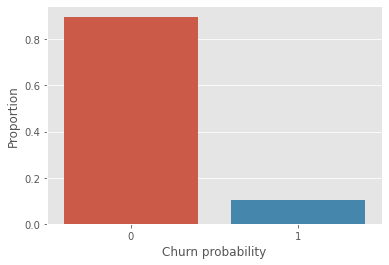

In [35]:
sns.barplot(data=data["churn_probability"].value_counts(normalize=True).reset_index(),
            x="index", y="churn_probability")
plt.xlabel("Churn probability")
plt.ylabel("Proportion")
plt.show()

The distribution of churn and not churn is clearly not equally distributed

##### Relationship of target variable and total_rech_amt

<AxesSubplot:xlabel='churn_probability', ylabel='total_rech_amt'>

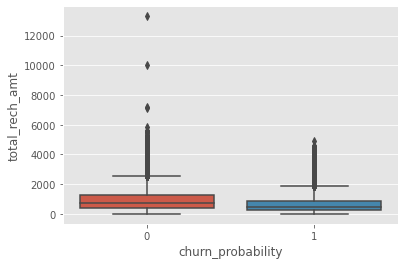

In [36]:
sns.boxplot(data=data, x="churn_probability", y="total_rech_amt")

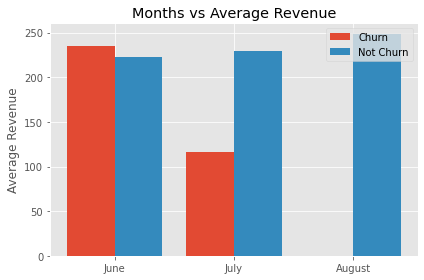

In [37]:
labels = ['June', 'July', 'August']
x = np.arange(len(labels))  # the label locations
width = 0.40  # the width of the bars

churn_df = data[data["churn_probability"] == 1]
non_churn_df = data[data["churn_probability"] == 0]

churn_1 = [ (churn_df["total_rech_amt_6"]).median(),
           (churn_df["total_rech_amt_7"]).median(),
           (churn_df["total_rech_amt_8"]).median()]

churn_2 = [ (non_churn_df["total_rech_amt_6"]).median(),
           (non_churn_df["total_rech_amt_7"]).median(),
           (non_churn_df["total_rech_amt_8"]).median()]

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, churn_1, width, label='Churn')
rects2 = ax.bar(x + width/2, churn_2, width, label='Not Churn')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Revenue')
ax.set_title('Months vs Average Revenue')
ax.legend()
plt.xticks(x, labels)

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

We can see from here that if customer is recharging less consecutively from june to july to august he/she is more likely to churn

##### Relationship of target variable and arpu

<AxesSubplot:xlabel='churn_probability', ylabel='arpu'>

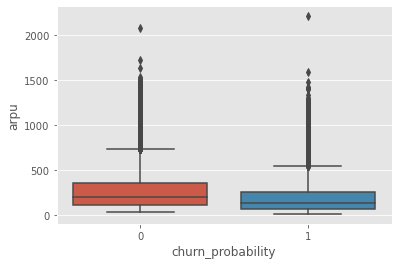

In [38]:
sns.boxplot(data=data, x="churn_probability", y="arpu")

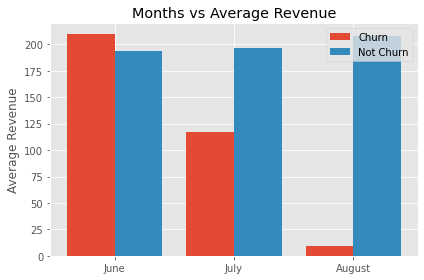

In [39]:
labels = ['June', 'July', 'August']
x = np.arange(len(labels))  # the label locations
width = 0.40  # the width of the bars

churn_df = data[data["churn_probability"] == 1]
non_churn_df = data[data["churn_probability"] == 0]

churn_1 = [ (churn_df["arpu_6"]).median(),
           (churn_df["arpu_7"]).median(),
           (churn_df["arpu_8"]).median()]

churn_2 = [ (non_churn_df["arpu_6"]).median(),
           (non_churn_df["arpu_7"]).median(),
           (non_churn_df["arpu_8"]).median()]

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, churn_1, width, label='Churn')
rects2 = ax.bar(x + width/2, churn_2, width, label='Not Churn')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Revenue')
ax.set_title('Months vs Average Revenue')
ax.legend()
plt.xticks(x, labels)

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

Similarly if the revenue of the customer is descreasing month over month, she/he is likely to churn

##### Target variable with data volume consumed

<AxesSubplot:xlabel='churn_probability', ylabel='total_vol_2g_3g'>

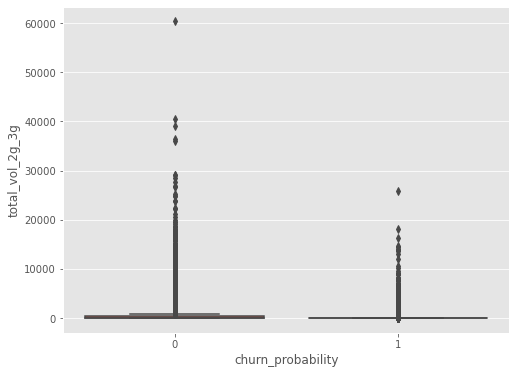

In [40]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x="churn_probability", y="total_vol_2g_3g")

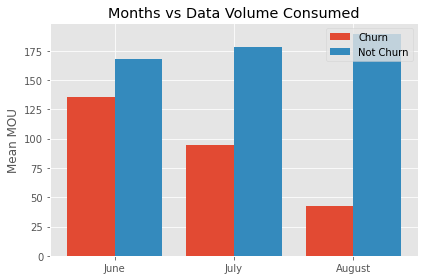

In [41]:
labels = ['June', 'July', 'August']
x = np.arange(len(labels))  # the label locations
width = 0.40  # the width of the bars

churn_df = data[data["churn_probability"] == 1]
non_churn_df = data[data["churn_probability"] == 0]

churn_1 = [ (churn_df["vol_3g_mb_6"] + churn_df["vol_2g_mb_6"]).mean(),
           (churn_df["vol_3g_mb_7"] + churn_df["vol_2g_mb_7"]).mean(),
           (churn_df["vol_3g_mb_8"] + churn_df["vol_2g_mb_8"]).mean()]

churn_2 = [ (non_churn_df["vol_3g_mb_6"] + non_churn_df["vol_2g_mb_6"]).mean(),
           (non_churn_df["vol_3g_mb_7"] + non_churn_df["vol_2g_mb_7"]).mean(),
           (non_churn_df["vol_3g_mb_8"] + non_churn_df["vol_2g_mb_8"]).mean()]

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, churn_1, width, label='Churn')
rects2 = ax.bar(x + width/2, churn_2, width, label='Not Churn')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean MOU')
ax.set_title('Months vs Data Volume Consumed')
ax.legend()
plt.xticks(x, labels)

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

Trend is low data consumption customers are likely to churn

##### Churn vs last recharge

<AxesSubplot:xlabel='churn_probability', ylabel='date_of_last_rech_8'>

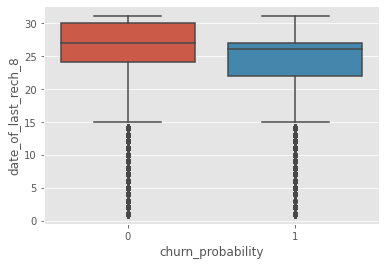

In [42]:
sns.boxplot(data=data, x="churn_probability", y="date_of_last_rech_8")

Not a significance difference, but if a customer has not recharged lately, then she/he is likely to churn

##### Target and age on network

<AxesSubplot:xlabel='churn_probability', ylabel='aon'>

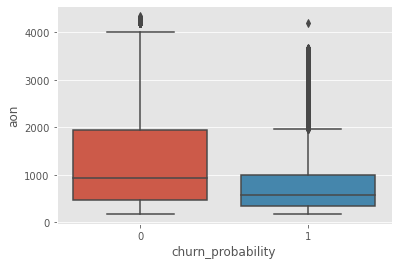

In [43]:
sns.boxplot(data=data, x="churn_probability", y="aon")

Here we can see if user age on the network is more, he/she is less likely to churn

##### Churn vs min usages

<AxesSubplot:xlabel='churn_probability', ylabel='total_mou'>

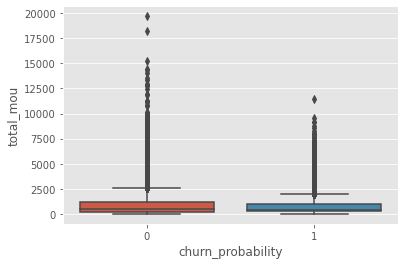

In [44]:
sns.boxplot(data=data, x="churn_probability", y="total_mou")

We can see much difference, let see in details month wise

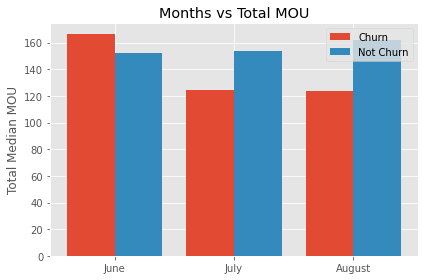

In [45]:
labels = ['June', 'July', 'August']
x = np.arange(len(labels))  # the label locations
width = 0.40  # the width of the bars

churn_df = data[data["churn_probability"] == 1]
non_churn_df = data[data["churn_probability"] == 0]

churn_1 = [ (churn_df["onnet_mou_6"] + churn_df["offnet_mou_6"]).median(),
           (churn_df["onnet_mou_7"] + churn_df["offnet_mou_7"]).median(),
           (churn_df["onnet_mou_8"] + churn_df["offnet_mou_8"]).median()]

churn_2 = [ (non_churn_df["onnet_mou_6"] + non_churn_df["offnet_mou_6"]).median(),
           (non_churn_df["onnet_mou_7"] + non_churn_df["offnet_mou_7"]).median(),
           (non_churn_df["onnet_mou_8"] + non_churn_df["offnet_mou_8"]).median()]

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, churn_1, width, label='Churn')
rects2 = ax.bar(x + width/2, churn_2, width, label='Not Churn')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Total Median MOU')
ax.set_title('Months vs Total MOU')
ax.legend()
plt.xticks(x, labels)

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

Here we can see that if usage is declining the customer is likely to churn

**Performing EDA gave us following insights**
- If customer is recharging less month on month he/she is likely to churn
- If customer's revenue is decreasing month on month he/she is likely to churn
- Customer consuming less internet data is likely to churn
- If is a customer has not done recharge lately, he/she might end up churning
- Customer who is using the network for long enough is not likely to churn
- If total voice call usage is declining month over month customer will likely churn

## 3. Data preparation

##### Checking for correlation

In [46]:
cor = data.corr()
cor.loc[:,:] = np.tril(cor, k=-1)
cor = cor.stack()
cor[(cor > 0.60) | (cor < -0.60)].sort_values()

total_ic_mou_8    loc_ic_t2m_mou_7    0.602712
std_og_t2m_mou_8  offnet_mou_7        0.605349
total_vol_2g_3g   jul_vbc_3g          0.605787
std_ic_mou_6      std_ic_t2m_mou_7    0.606345
monthly_3g_8      vol_3g_mb_8         0.607377
                                        ...   
total_mou         total_og_mou_7      0.920315
total_rech_amt_6  arpu_6              0.927123
total_rech_amt_7  arpu_7              0.928217
total_rech_amt_8  arpu_8              0.932994
total_rech_amt    arpu                0.979842
Length: 229, dtype: float64

There are quiet a few number of correlated features but we'll not remove those, as we'll go ahead and do PCA

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69363 entries, 0 to 69998
Columns: 130 entries, arpu_6 to total_mou
dtypes: float64(106), int64(24)
memory usage: 71.3 MB


#### Splitting and scaling the data

In [48]:
y = data.pop("churn_probability")
X = data

In [49]:
sm = SMOTE(random_state=100)
X, y = sm.fit_resample(X, y)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, 
                                                    random_state=1)

In [51]:
scaler = StandardScaler()

In [52]:
X_train = scaler.fit_transform(X_train)

In [53]:
pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
0,-0.055644,-0.062304,-0.020227,-0.369595,-0.377434,-0.357581,-0.313915,-0.419387,-0.479897,-0.101425,...,3.322007,3.496675,0.206947,-0.083066,0.453487,-0.219859,-0.057828,0.143042,0.926582,-0.589567
1,-0.277561,-0.835319,-0.786455,0.761022,-0.427423,-0.403896,-0.411897,-0.594353,-0.601685,-0.168874,...,-0.177464,-0.172651,-0.837117,-0.208839,-0.218079,-0.219859,-0.767266,-0.745295,-0.326169,-0.390001
2,-0.553088,-0.076844,-0.521636,0.030361,0.391223,-0.242137,-0.610605,-0.361707,-0.544367,-0.175238,...,-0.177464,-0.172651,-0.928301,-0.208839,-0.218079,-0.219859,-0.476142,-0.590743,-0.303253,-0.333646
3,2.197696,-0.162489,-0.785959,-0.443543,-0.424808,-0.331749,-0.444458,-0.541236,-0.393608,-0.105502,...,-0.177464,-0.172651,-0.824579,-0.208839,-0.218079,-0.219859,0.599429,0.589227,-0.326169,-0.668467
4,0.360007,0.796203,-0.326072,2.073711,0.857117,3.022694,-0.369395,-0.317962,-0.438017,-0.175238,...,-0.177464,-0.172651,-0.456421,-0.208839,-0.218079,-0.219859,0.359124,0.440050,-0.326169,1.179221


In [54]:
X_test = scaler.transform(X_test)

In [55]:
pd.DataFrame(X_test).head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
0,-0.234668,-0.241678,0.230278,-0.257276,-0.289315,0.085586,-0.058249,-0.037397,0.075182,-0.175238,...,-0.177464,-0.172651,0.563707,-0.208839,-0.218079,-0.219859,-0.113708,0.067782,-0.326169,-0.140981
1,0.101635,0.035570,0.135435,-0.395896,-0.357804,-0.379722,-0.256046,-0.260233,-0.452508,-0.175238,...,-0.177464,-0.172651,1.965671,0.463268,-0.218079,-0.219859,0.111522,-0.155310,1.592294,-0.531624
2,1.454226,1.462443,1.456517,-0.459173,-0.422809,-0.389625,-0.634620,-0.541321,-0.523788,-0.175238,...,-0.177464,-0.172651,-0.426786,4.638885,3.072906,1.405836,1.800745,1.728879,6.119456,-0.768361
3,-0.283257,-0.914072,-0.786455,-0.255850,-0.314776,-0.265082,-0.211639,-0.279053,-0.217895,-0.073389,...,-0.177464,-0.172651,-0.894107,-0.208839,-0.218079,-0.219859,-0.802024,-0.803084,-0.326169,-0.395891
4,-0.940239,0.170437,-0.786455,-0.456666,-0.318479,-0.265082,-0.597675,0.369690,-0.217895,-0.175238,...,-0.177464,-0.172651,-0.866752,-0.208839,-0.218079,-0.219859,-0.647516,-0.639125,-0.326169,-0.392490


#### PCA

In [56]:
pca = PCA(random_state=100)
X_train_pca = pca.fit_transform(X_train)

In [57]:
columns = [f"PCA{i}" for i in range(1, len(X_train_pca[0]) + 1)]
X_train_pca = pd.DataFrame(X_train_pca, columns=columns)
X_train_pca.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,...,PCA120,PCA121,PCA122,PCA123,PCA124,PCA125,PCA126,PCA127,PCA128,PCA129
0,-0.397363,2.496242,2.712979,0.258817,-0.938712,-0.515479,0.792979,-2.016650,0.706625,-1.047896,...,9.430521e-06,2.065796e-05,0.000009,0.000014,-0.000003,7.515649e-14,2.344515e-14,-1.704336e-14,2.533872e-16,6.335569e-16
1,-3.424818,-1.512741,-0.413360,-0.356134,-1.008738,0.188036,0.671400,-0.242772,-0.177690,0.020032,...,-2.589166e-07,6.165737e-06,0.000001,0.000002,-0.000008,-2.955513e-14,2.490249e-14,-1.045477e-14,2.347208e-16,6.986543e-16
2,-2.396361,-1.128777,-0.343452,0.067815,0.339770,0.369729,0.854762,-0.217882,-0.101239,0.026260,...,-7.821691e-06,1.432905e-05,0.000014,0.000001,0.000004,-3.742427e-14,2.326427e-14,-1.481116e-14,7.578936e-16,1.161230e-15
3,-1.809300,-0.797285,0.581279,-0.584472,-2.306440,-1.024760,-0.116879,0.375808,0.124479,1.053918,...,2.398440e-06,6.969956e-07,-0.000003,-0.000003,0.000002,2.094893e-15,3.346717e-15,-6.073313e-15,3.517144e-17,-1.964139e-16
4,6.579275,4.629696,-4.274510,-4.103750,0.639210,2.084942,5.845237,1.736635,-0.645405,-3.426030,...,-4.253620e-05,1.631036e-05,-0.000020,-0.000002,0.000005,-5.093524e-15,8.459218e-15,5.138672e-15,3.324866e-16,1.299920e-16


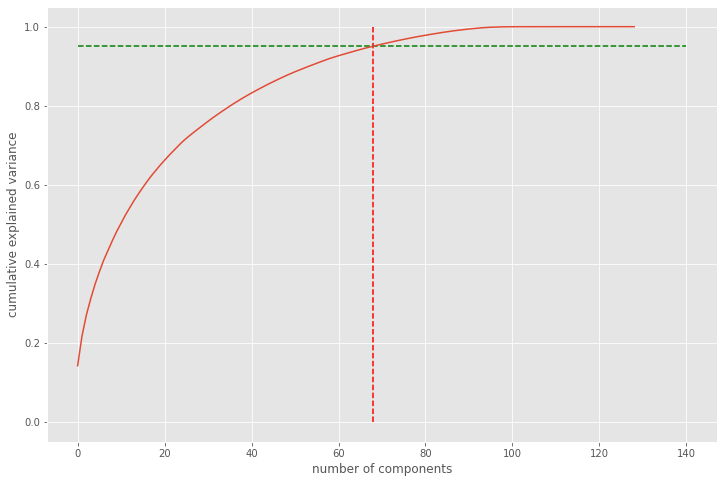

In [58]:
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.vlines(x=68, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=140, xmin=0, colors="g", linestyles="--")
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

We can see that 68 components are able to explain more than 95% of the variance. So lets select the number of components as 68 and create a new dataset

In [59]:
pca = PCA(0.95, random_state=100)
X_train_pca = pca.fit_transform(X_train)

In [60]:
columns = [f"PCA{i}" for i in range(1, len(X_train_pca[0]) + 1)]
X_train_pca = pd.DataFrame(X_train_pca, columns=columns)
X_train_pca.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,...,PCA60,PCA61,PCA62,PCA63,PCA64,PCA65,PCA66,PCA67,PCA68,PCA69
0,-0.397363,2.496242,2.712979,0.258817,-0.938712,-0.515479,0.792979,-2.016650,0.706625,-1.047896,...,-0.164806,0.428687,0.145679,0.031858,-0.742494,1.616227,0.157504,-0.129887,-0.020768,-0.166225
1,-3.424818,-1.512741,-0.413360,-0.356134,-1.008738,0.188036,0.671400,-0.242772,-0.177690,0.020032,...,-0.048502,-0.024646,-0.048980,-0.124340,0.241612,-0.113357,0.187565,-0.385885,-0.080192,-0.052710
2,-2.396361,-1.128777,-0.343452,0.067815,0.339770,0.369729,0.854762,-0.217882,-0.101239,0.026260,...,0.011196,0.231026,-0.355654,0.293280,0.209410,-0.022865,-0.085147,0.386886,0.208810,-0.091381
3,-1.809300,-0.797285,0.581279,-0.584472,-2.306440,-1.024760,-0.116879,0.375808,0.124479,1.053918,...,0.297838,1.076386,-1.893761,-0.342657,-0.624390,0.060618,0.341169,0.144697,-0.033546,0.180264
4,6.579275,4.629696,-4.274510,-4.103750,0.639210,2.084942,5.845237,1.736635,-0.645405,-3.426030,...,-0.498985,0.422176,0.380123,0.640284,-0.075587,0.039544,1.118713,-1.497566,-0.624439,-0.070999


In [61]:
X_test_pca = pca.transform(X_test)

In [62]:
columns = [f"PCA{i}" for i in range(1, len(X_test_pca[0]) + 1)]
X_test_pca = pd.DataFrame(X_test_pca, columns=columns)
X_test_pca.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,...,PCA60,PCA61,PCA62,PCA63,PCA64,PCA65,PCA66,PCA67,PCA68,PCA69
0,-0.381265,0.437196,-0.164914,0.582480,0.613384,-1.968005,0.435254,0.628109,0.692634,-0.967189,...,-0.085053,0.347264,0.651406,0.542733,-0.145984,-0.010512,0.088119,-0.424848,-0.140735,0.142644
1,-0.743378,1.703990,3.096246,-0.365135,0.105202,1.535277,-0.724522,1.597787,-0.689921,1.595130,...,0.293475,-0.318066,-0.372115,-0.108903,0.399402,-1.324049,-0.147306,0.075633,0.907848,-0.180090
2,4.795284,1.832022,12.499365,2.201891,0.569371,20.517278,-8.626871,13.231079,-1.443510,3.698977,...,0.023149,0.721426,0.764329,0.441035,-1.157195,-0.318798,0.118020,-0.628317,2.691655,-1.407117
3,-3.520203,-0.338545,-0.696952,-0.403274,-0.455754,-0.386864,0.198098,-0.400085,-0.513087,-0.467136,...,0.200809,0.068750,-0.100031,0.012341,-0.207736,0.051153,0.046982,0.012051,-0.032950,-0.136762
4,-2.394058,0.123310,-0.690504,-0.751381,0.529021,-0.247754,-0.217300,-0.037559,-0.630405,-0.359151,...,0.197678,-0.456717,-0.174491,-0.285128,0.128421,-0.082805,0.194121,-0.263265,0.021962,-0.168923


## 4. Modelling and evaluation

Let's applying LogisticRegression, DecisionTree and RandomForest to see which one gives the highest accuracy

In [63]:
model_metric = pd.DataFrame(index = ["Accuracy", "F1 score", "ROC AUC score", "Precision", "Recall"])
def print_metric(model_name, y_true, y_pred, y_pred_prob):
    acc = round(metrics.accuracy_score(y_true, y_pred), 5)
    f1 = round(metrics.f1_score(y_true, y_pred), 5)
    roc_auc = round(metrics.roc_auc_score(y_true, y_pred_prob[:,1]), 5)
    precision = round(metrics.precision_score(y_true, y_pred), 5)
    recall = round(metrics.recall_score(y_true, y_pred), 5)
    model_metric[model_name] = [acc, f1, roc_auc, precision, recall]
    print(model_metric[model_name])
    
def predict_and_print(model_name, model, X, y):
    y_pred_prob = model.predict_proba(X)
    y_pred = model.predict(X)
    print_metric(model_name, y, y_pred, y_pred_prob)

#### Logistic Regression

In [64]:
logistic_pca = LogisticRegression(random_state=100)

In [65]:
model_pca = logistic_pca.fit(X_train_pca, y_train)

In [66]:
predict_and_print("LR_Train", model_pca, X_train_pca, y_train)

Accuracy         0.82658
F1 score         0.83336
ROC AUC score    0.89855
Precision        0.80359
Recall           0.86542
Name: LR_Train, dtype: float64


In [67]:
predict_and_print("LR_Test", model_pca, X_test_pca, y_test)

Accuracy         0.82534
F1 score         0.83207
ROC AUC score    0.89699
Precision        0.79747
Recall           0.86981
Name: LR_Test, dtype: float64


#### Logistic Regression without PCA

In [68]:
logistic = LogisticRegression(random_state=100)

In [69]:
model = logistic.fit(X_train, y_train)

In [70]:
predict_and_print("LR_Train", model, X_train, y_train)

Accuracy         0.86730
F1 score         0.86785
ROC AUC score    0.93371
Precision        0.86606
Recall           0.86965
Name: LR_Train, dtype: float64


In [71]:
predict_and_print("LR_Test", model, X_test, y_test)

Accuracy         0.86578
F1 score         0.86601
ROC AUC score    0.93236
Precision        0.86024
Recall           0.87185
Name: LR_Test, dtype: float64


#### Decision tree

Lets do Cross Validation to do hyperparameter tuning

In [72]:
dt = DecisionTreeClassifier(random_state=100)

In [73]:
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [74]:
%%time
grid_search.fit(X_train_pca, y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
Wall time: 2min 49s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=100),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='accuracy', verbose=1)

In [75]:
grid_search.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_leaf=5,
                       random_state=100)

In [76]:
dt_best = grid_search.best_estimator_

In [77]:
predict_and_print("DT_Train", dt_best, X_train_pca, y_train)

Accuracy         0.96523
F1 score         0.96524
ROC AUC score    0.99665
Precision        0.96703
Recall           0.96346
Name: DT_Train, dtype: float64


In [78]:
predict_and_print("DT_Test", dt_best, X_test_pca, y_test)

Accuracy         0.85871
F1 score         0.86025
ROC AUC score    0.88930
Precision        0.84682
Recall           0.87411
Name: DT_Test, dtype: float64


#### Decision tree without PCA

In [79]:
dt_2 = DecisionTreeClassifier(random_state=100)

In [80]:
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}
grid_search = GridSearchCV(estimator=dt_2, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [81]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
Wall time: 2min 35s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=100),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='accuracy', verbose=1)

In [82]:
dt_best_2 = grid_search.best_estimator_

In [83]:
predict_and_print("DT_Train", dt_best_2, X_train, y_train)

Accuracy         0.93462
F1 score         0.93519
ROC AUC score    0.97754
Precision        0.92898
Recall           0.94149
Name: DT_Train, dtype: float64


In [84]:
predict_and_print("DT_Test", dt_best_2, X_test, y_test)

Accuracy         0.91633
F1 score         0.91670
ROC AUC score    0.96203
Precision        0.90823
Recall           0.92533
Name: DT_Test, dtype: float64


#### Random Forest

In [85]:
rf = RandomForestClassifier(random_state=100, n_jobs=-1)

In [86]:
params = {
    'max_depth': [10,20,30,40],
    'min_samples_leaf': [3,5,10,20],
    'n_estimators': [10, 25, 50, 100]
}
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [87]:
%%time
grid_search.fit(X_train_pca, y_train)

Fitting 4 folds for each of 64 candidates, totalling 256 fits
Wall time: 17min 54s


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=100),
             n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, 40],
                         'min_samples_leaf': [3, 5, 10, 20],
                         'n_estimators': [10, 25, 50, 100]},
             scoring='accuracy', verbose=1)

In [88]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=30, min_samples_leaf=3, n_jobs=-1,
                       random_state=100)

In [89]:
rf_best = grid_search.best_estimator_

In [90]:
predict_and_print("RF_Train", rf_best, X_train_pca, y_train)

Accuracy         0.99362
F1 score         0.99366
ROC AUC score    0.99985
Precision        0.99018
Recall           0.99716
Name: RF_Train, dtype: float64


In [91]:
predict_and_print("RF_Test", rf_best, X_test_pca, y_test)

Accuracy         0.92458
F1 score         0.92538
ROC AUC score    0.97732
Precision        0.91119
Recall           0.94002
Name: RF_Test, dtype: float64


#### Random Forest without PCA

In [92]:
rf_2 = RandomForestClassifier(random_state=100, n_jobs=-1)

In [93]:
params = {
    'max_depth': [10,20,30,40],
    'min_samples_leaf': [3,5,10,20],
    'n_estimators': [10, 25, 50, 100]
}
grid_search = GridSearchCV(estimator=rf_2,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [94]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 64 candidates, totalling 256 fits
Wall time: 13min 30s


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=100),
             n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, 40],
                         'min_samples_leaf': [3, 5, 10, 20],
                         'n_estimators': [10, 25, 50, 100]},
             scoring='accuracy', verbose=1)

In [95]:
rf_best_2 = grid_search.best_estimator_

In [96]:
predict_and_print("RF_Train", rf_best_2, X_train, y_train)

Accuracy         0.99042
F1 score         0.99048
ROC AUC score    0.99967
Precision        0.98627
Recall           0.99473
Name: RF_Train, dtype: float64


In [97]:
predict_and_print("RF_Test", rf_best_2, X_test, y_test)

Accuracy         0.95322
F1 score         0.95313
ROC AUC score    0.98939
Precision        0.95007
Recall           0.95621
Name: RF_Test, dtype: float64


#### XGBoost

In [98]:
xgb_cfl_pca = xgb.XGBClassifier(n_jobs = -1,objective = 'binary:logistic')

In [99]:
xgb_cfl_pca.fit(X_train_pca, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [100]:
predict_and_print("XGBoost_Train", xgb_cfl_pca, X_train_pca, y_train)

Accuracy         0.95741
F1 score         0.95803
ROC AUC score    0.99159
Precision        0.94615
Recall           0.97022
Name: XGBoost_Train, dtype: float64


In [101]:
predict_and_print("XGBoost_Test", xgb_cfl_pca, X_test_pca, y_test)

Accuracy         0.91451
F1 score         0.91588
ROC AUC score    0.96855
Precision        0.89716
Recall           0.93539
Name: XGBoost_Test, dtype: float64


#### XG Boost without PCA

In [102]:
xgb_cfl = xgb.XGBClassifier(n_jobs = -1,objective = 'binary:logistic')

In [103]:
xgb_cfl.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [104]:
predict_and_print("XGBoost_Train", xgb_cfl, X_train, y_train)

Accuracy         0.98606
F1 score         0.98607
ROC AUC score    0.99917
Precision        0.98744
Recall           0.98471
Name: XGBoost_Train, dtype: float64


In [105]:
predict_and_print("XGBoost_Test", xgb_cfl, X_test, y_test)

Accuracy         0.96585
F1 score         0.96569
ROC AUC score    0.99450
Precision        0.96533
Recall           0.96605
Name: XGBoost_Test, dtype: float64


#### Comparision

Model comparision without PCA

In [106]:
model_metric

,LR_Train,LR_Test,DT_Train,DT_Test,RF_Train,RF_Test,XGBoost_Train,XGBoost_Test
Accuracy,0.86730,0.86578,0.93462,0.91633,0.99042,0.95322,0.98606,0.96585
F1 score,0.86785,0.86601,0.93519,0.91670,0.99048,0.95313,0.98607,0.96569
ROC AUC score,0.93371,0.93236,0.97754,0.96203,0.99967,0.98939,0.99917,0.99450
Precision,0.86606,0.86024,0.92898,0.90823,0.98627,0.95007,0.98744,0.96533
Recall,0.86965,0.87185,0.94149,0.92533,0.99473,0.95621,0.98471,0.96605


**We can see that among all of these models XG Boost is performing the best**

### 5. Variable importance

In [107]:
imp_df = pd.DataFrame({
    "Varname": X.columns,
    "Imp": xgb_cfl.feature_importances_
})

In [108]:
imp_df.sort_values(by="Imp", ascending=False).head(10)

,Varname,Imp
81,total_ic_mou_8,0.221810
14,roam_og_mou_8,0.072725
11,roam_ic_mou_8,0.036143
65,loc_ic_mou_8,0.030869
114,monthly_2g_8,0.026858
102,date_of_last_rech_8,0.026565
96,total_rech_amt_8,0.022004
113,monthly_2g_7,0.018517
105,last_day_rch_amt_8,0.018096
47,spl_og_mou_7,0.016933


## Conclusion

**Performing EDA gave us following insights**
- If customer is recharging less month on month he/she is likely to churn
- If customer's revenue is decreasing month on month he/she is likely to churn
- Customer consuming less internet data is likely to churn
- If is a customer has not done recharge lately, he/she might end up churning
- Customer who is using the network for long enough is not likely to churn
- If total voice call usage is declining month over month customer will likely churn

**XGBClassifier** without applying PCA gives the best test accuracy of **0.96585** with following hyperparameters
- learning_rate=0.3
- max_depth=6
- n_estimators=100

Few **Important features** are as follows
- Total incoming voice calls in the month of august
- Total outgoing voice calls in the month of august
- Average revenue per user in the month of august
- Total amount of recharge done in the month of august
- Maximum amount of recharge done in the month of august

## Testing with Kaggle test data

In [109]:
df_test = pd.read_csv("test (1).csv")

#### Applying transformations

In [110]:
df_test['date_of_last_rech_6'] = pd.to_datetime(df_test['date_of_last_rech_6'], infer_datetime_format=True).dt.day

In [111]:
df_test['date_of_last_rech_7'] = pd.to_datetime(df_test['date_of_last_rech_7'], infer_datetime_format=True).dt.day

In [112]:
df_test['date_of_last_rech_8'] = pd.to_datetime(df_test['date_of_last_rech_8'], infer_datetime_format=True).dt.day

In [113]:
df_test["total_rech_amt"] = df_test["total_rech_amt_6"] + df_test["total_rech_amt_7"] + df_test["total_rech_amt_8"]

In [114]:
df_test["total_vol_2g_3g"] = df_test["vol_2g_mb_6"] + df_test["vol_2g_mb_7"] + df_test["vol_2g_mb_8"] + df_test["vol_3g_mb_6"] + df_test["vol_3g_mb_7"] + df_test["vol_3g_mb_8"]

In [115]:
df_test["arpu"] = (df_test["arpu_6"] + df_test["arpu_7"] + df_test["arpu_8"] ) / 3

In [116]:
df_test["total_mou"] = df_test["onnet_mou_6"] + df_test["onnet_mou_7"] + df_test["onnet_mou_8"] + df_test["offnet_mou_6"] + df_test["offnet_mou_7"] + df_test["offnet_mou_8"]

#### Dropping columns and treating null values

In [117]:
df_test = df_test[X.columns]

In [118]:
df_test.fillna(df_test.median(), inplace=True)

#### Preparing data

In [119]:
X_test_kaggle = scaler.transform(df_test)

#### Predicting

In [121]:
y_test_pred_kaggle = xgb_cfl.predict(X_test_kaggle)

#### Preparing output file

In [122]:
df_final_kaggle = pd.read_csv("solution (1).csv")

In [123]:
df_final_kaggle.drop("churn_probability", axis=1, inplace=True)

In [124]:
df_final_kaggle["churn_probability"] = y_test_pred_kaggle

In [125]:
df_final_kaggle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   id                 30000 non-null  int64
 1   churn_probability  30000 non-null  int32
dtypes: int32(1), int64(1)
memory usage: 351.7 KB


In [126]:
df_final_kaggle.to_csv("submission.csv", index=False)